## Aiyagari With Fat Tailed Wealth distribution with a Continuum of Types 

Carlos Lizama

The system to be solve is the following:
\begin{align*}
\rho v(a,z) & = \max_{c,0 \leq k \leq a+\phi} u(c) + v_a(a,z) (wz + ra + (R-r)k - c) + \frac{1}{2} \partial_{aa}v(a,z) \sigma^2 k^2 + \mu(z) \partial_z v(a,z) + \frac{\sigma_z^2}{2} \partial_{zz} v(a,z) \\
0 & = - \frac{d}{da} [s_(a)g_(a,z)] + \frac{1}{2} \frac{d^2}{da^2} [\sigma^2 k(a,z)^2 g(a,z)] - \partial_z [\mu(z) g(a,z)] + \frac{1}{2} \partial_{zz} [\sigma_z^2 g(a,z)]
\end{align*}



### Parameters of the economy, primitives and grids

In [1]:
"""
Define type FatTailContTypes
    
    # parameters of the economy
    γ::Float64           # CRRA paramter
    ρ::Float64           # discount rate
    ϕ::Float64           # borrowing limit
    θ::Float64           # persistence of productivity process
    σz::Float64          # variance of productivity process

    # parameters of the algorithm
    maxiter::Int64       # maximum number of interation
    tol::Float64         # tolerance of the algorithm. When the distance in two iteration is lower, stop.
    Δ::Float64           # step of the algorithm. See discussion of this parameter in the paper.

    # parameters of the economy: partial equilibrium
    w::Float64           # wage
    R::Float64           # Mean of interest rate of risky asset
    r::Float64           # risk free rate

    # other parameters
    η::Float64           # tail parameter of wealth distribution. I changed this greek letter, previously ζ.
    σ²::Float64          # variance of risky asset
    cslope::Float64      # slope of policy function for consumption, derived theoretically in the paper.

    # grid parameters
    I::Int64             # number of points in asset grid
    J::Int64             # number of points in productivity grid
    z::Arra{Float64,1}   # productivity grid
    a::Array{Float64,1}  # asset grid

    # value functions and policy functions. Construct Aswitch matrix, matrix wi
    c::Array{Float64,2}        # policy function: consumption
    k::Array{Float64,2}        # policy function: risky asset
    v::Array{Float64,2}        # value function.
    C::Array{Float64,2}        # Matrix used in Kolmogorov Forward eq.
    A::Array{Float64,2}        # Matrix used in Kolmogorov Forward eq.

"""
type FatTailContTypes
    
    # parameters of the economy
    γ::Float64
    ρ::Float64
    ϕ::Float64
    θ::Float64
    
    # parameters of the economy: partial equilibrium
    w::Float64
    R::Float64
    r::Float64
    
    # other parameters
    η::Float64
    σ²::Float64
    cslope::Float64
    
    # grid parameters
    I::Int64
    J::Int64
    z::Array{Float64,1}
    a::Array{Float64,1}
    
    # value functions and policy functions. Construct Aswitch matrix, matrix wi
    c::Array{Float64,2}
    k::Array{Float64,2}
    v::Array{Float64,2}
    C::SparseMatrixCSC{Float64,Int64}
    A::SparseMatrixCSC{Float64,Int64}
end

In [2]:
"""
Constructor of AiyagariFatTail type. It constructs the object with default values according to the paper.
"""
function FatTailContTypes(;γ=2., ρ=.05, ϕ=0.3, θ=-log(.9), var=.07, w=.5, R=.051, r=.041, η=1.5, I=5000, J=50, amax=1000)
    
    σ² = (η/γ + 1)*(R-r)^2/(2*(ρ-r))
    cslope = (ρ - (1-γ)*r)/γ - (1-γ)/(2*γ)*(R-r)^2/(γ*σ²)
    
    amin = -ϕ
    
    # define grid for asset
    x = linspace(0,1,I)
    coeff = 5
    power = 10
    xx = x + coeff*x.^power
    xmax = maximum(xx)
    xmin = minimum(xx)
    a = (amax-amin)/(xmax - xmin)*xx + amin
    
    # define grid for productivity types
    zmean = exp(var/2)
    stdz = sqrt(2*θ*var)
    zmin = zmean - 1.98*stdz
    zmax = zmean + 1.98*stdz
    z = linspace(zmin, zmax, J)
    Δz = (zmax-zmin)/(J-1)
    μ = (-θ*log(z)+stdz^2/2).*z
    σz = stdz*z
    
    # initialize value function and policy functions
    c = zeros(I,J)
    k = zeros(I,J)
    v = zeros(I,J)

    # define matrix C
    χ = σz.^2/(2*(Δz)^2)
    υ = - μ/Δz - σz.^2/(Δz)^2
    ζ = μ/Δz + σz.^2/(2*(Δz)^2)
    C = spdiagm(υ,0,J,J) + spdiagm(χ[2:end],-1,J,J) + spdiagm(ζ[1:end-1],1,J,J)
    C[1,1] = C[1,1] + χ[1]
    C[J,J] = C[J,J] + ζ[J]
    C = kron(C,speye(I))
    A = speye(I*J)

    FatTailContTypes(γ, ρ, ϕ, θ, w, R, r, η, σ², cslope, I, J, z, a, c, k, v, C, A)
    
end

FatTailContTypes

In [3]:
"""
This function unpacks the elements inside the AiyagariFatTail type.
"""
function unpack(h::FatTailContTypes)
    return h.γ, h.ρ, h.ϕ, h.θ, h.w, h.R, h.r, h.η, h.σ², h.cslope, h.I, h.J, h.z, h.a, h.c, h.k, h.v, h.C, h.A    
end

unpack (generic function with 1 method)

In [4]:
"""
This function solves the Hamilton-Jacobi-Bellman equation.
"""
function solveHJB!(h::FatTailContTypes)
    γ, ρ, ϕ, θ, w, R, r, η, σ², cslope, I, J, z, a, c, k, v, C, A = unpack(h)
    amax = maximum(a)
    
    # create (square) grids
    aa = repmat(a,1,J)
    zz = repmat(z',I,1)
    
    # initial guess
    v = (w*zz + r*aa).^(1-γ)/(ρ*(1-γ))
    
    # forward and backward differences of the grid
    daf = ones(I)
    dab = ones(I)
    daf[1:I-1] = a[2:I]-a[1:I-1]
    dab[2:I] = a[2:I]-a[1:I-1]
    daf[I] = daf[I-1]
    dab[1] = dab[2]

    daaf = repmat(daf,1,J)
    daab = repmat(dab,1,J)

    # objects for approximation of second derivatives (see expresion for approx. second derivatives in the pdf file)
    denom = (daaf + daab).*(daab.*daaf)/2
    weightf = daab./denom
    weight0 = -(daab + daaf)./denom
    weightb = daaf./denom
    
    # initialize value function and policy functions
    dVf = zeros(I,J)
    dVb = zeros(I,J)
    dV0 = zeros(I,J)
    dV2f = zeros(I,J)
    dV2b = zeros(I,J)
    c = zeros(I,J)
    c0 = zeros(I,J)
    v0 = zeros(I,J)
    ssb = zeros(I,J)
    ssf = zeros(I,J)
    k = zeros(I,J)    
    
    Δ = 10000
    iter = 0
    dist = 1
    tol = 1e-6
    while dist>tol
    
        V = copy(v)
        
        # forward difference
        dVf[1:I-1,:] = (V[2:I,:] - V[1:I-1,:])./(aa[2:I,:]-aa[1:I-1,:])
        dVf[I,:] = (w*z' + r*amax).^(-γ)*(1-(R-r)^2/(cslope*γ*σ²))^(γ) # upper boundary condition

        # backward difference
        dVb[2:I,:] = (V[2:I,:] - V[1:I-1,:])./(aa[2:I,:]-aa[1:I-1,:])
        dVb[1,:] = (w*z' + r*a[1]).^(-γ)  # lower boundary condition

        # second derivative (forward and backward only differ at amax)
        dV2b[2:I-1,:] = (daab[2:I-1,:].*V[3:I,:]-(daab[2:I-1,:]+daaf[2:I-1,:]).*V[2:I-1,:]+daaf[2:I-1,:].*V[1:I-2,:])./
        denom[2:I-1,:]
        dV2f[2:I-1,:] = (daab[2:I-1,:].*V[3:I,:]-(daab[2:I-1,:]+daaf[2:I-1,:]).*V[2:I-1,:]+daaf[2:I-1,:].*V[1:I-2,:])./
        denom[2:I-1,:]
        dV2b[I,:] = -γ*dVb[I,:].^(1+1/γ)*cslope  # boundary condition for second derivative
        dV2f[I,:] = -γ*dVf[I,:].^(1+1/γ)*cslope

        I_concave = dVb .> dVf  # check whether value function is concave (problems arise if this is not the case)

        # consumption and savings with forward difference
        cf = dVf.^(-1/γ)
        kf = max(- dVf./dV2f*(R-r)/σ²,0)
        kf = min(kf,aa+ϕ)
        ssf = w*zz + (R-r)*kf + r*aa - cf

        # consumption and savings with backward difference
        cb = dVb.^(-1/γ)
        kb = max(- dVb./dV2b*(R-r)/σ²,0)
        kb = min(kb,aa+ϕ)
        ssb = w*zz + (R-r)*kb + r*aa - cb

        # consumption and derivative of value function at steady state
        k0 = (kb+kf)/2
        c0 = w*zz + (R-r)*k0 + r*aa
        dV0 = c0.^(-γ)

        # Upwind scheme
        If = 1*(ssf.>1e-12)
        Ib = 1*(ssb.<-1e-12)
        I0 = (1-If-Ib)
        dV_Upwind = dVf.*If + dVb.*Ib + dV0.*I0
        c = dV_Upwind.^(-1/γ)
        u = c.^(1-γ)/(1-γ)
        k = max(-dV_Upwind./dV2b*(R-r)/σ²,0)
        k = min(k,aa+ϕ)

        # Construct matrix A
        X = -min(ssb,0)./daab + σ²/2*k.^2.*weightb
        Y = -max(ssf,0)./daaf + min(ssb,0)./daab + σ²/2*k.^2.*weight0
        Z = max(ssf,0)./daaf + σ²/2*k.^2.*weightf
        # boundary conditions at the top
        xi = -dVb[I,:].^(-1/γ)/cslope*(R-r)^2/(2*γ*σ²)
        X[I,:] = -min(ssb[I,:],0)./daab[I,:] - xi./daab[I,:]
        Y[I,:] = -max(ssf[I,:],0)./daaf[I,:] + min(ssb[I,:],0)./daab[I,:] + xi./daab[I,:]
        Z[I,:] = max(ssf[I,:],0)./daaf[I,:]
        X[1,:] = 0
        Z[I,:] = 0
        X = X[:]
        X = X[2:end]
        Y = Y[:]
        Z = Z[:]
        Z = Z[1:end-1]
        
        A = spdiagm(X,-1,I*J,I*J) + spdiagm(Y,0,I*J,I*J) + spdiagm(Z,1,I*J,I*J) + C

        B = (1/Δ + ρ)*speye(Float64,I*J) - A
        u_stacked = u[:]
        V_stacked = V[:]
        b = u_stacked + V_stacked/Δ

        # Solve system of equations
        V_stacked = B\b
        V = reshape(V_stacked,I,J)

        Vchange = V - v

        v = copy(V)
        iter += 1

        dist = vecnorm(Vchange,Inf)
        println(dist)
        println(iter)
        if dist < tol
            break
        end
        
    end
    
    h.v = v
    h.c = c
    h.k = k
    h.A = A

end

solveHJB! (generic function with 1 method)

In [5]:
"""
This function solves the Kolmogorov Forward equation. It receives and AiyagariFatTail type and returns 
a vector with the stationary distribution for each type (each type one column)
"""
function solveKF(h)
    
    a = h.a
    I = h.I
    J = h.J
    A = h.A
    
    # forward and backward differences of the grid
    daf = ones(I)
    dab = ones(I)
    daf[1:I-1] = a[2:I]-a[1:I-1]
    dab[2:I] = a[2:I]-a[1:I-1]
    
    # create matrix D
    da_tilde = (dab+daf)/2
    da_tilde[1] = daf[1]/2
    da_tilde[I] = dab[I]/2
    da_stacked = squeeze(repmat(da_tilde,J,1),2)
    D = spdiagm(da_stacked,0,I*J,I*J)
    Atilde = D*A*D.^(-1)
    AT = A'

    # find distributions, solve Atilda'g = 0
    b = zeros(I*J)
    b[1] = 1         # need to fix one value, then solve. Otherwise matrix is singular
    row = [1 zeros(1,I*J-1)]
    AT[1,:] = row

    gg = AT\b
    g_sum = gg'*da_stacked
    gg = gg/g_sum
    g = reshape(gg,I,J)
    
    return g
    
end

solveKF (generic function with 1 method)

In [12]:
# solve the model

h = FatTailContTypes()
@time solveHJB!(h)
@time g = solveKF(h)

9.737489503802351
1
0.7559364618481439
2
0.4039644475746016
3
0.08983158595251695
4
0.010266222169214245
5
0.001063730908661853
6
7.791308966886845e-6
7
5.538834813023641e-8
8
 35.840903 seconds (26.28 k allocations: 6.191 GB, 6.89% gc time)
  4.438819 seconds (2.50 M allocations: 610.512 MB, 4.38% gc time)


5000x50 Array{Float64,2}:
 0.0321148   0.0326592   0.0328517   0.0327235   …  0.000143097  0.000134078
 0.0134061   0.0137472   0.0140367   0.0142711      0.000458725  0.000434104
 0.0112808   0.0115693   0.0118175   0.0120233      0.000875468  0.00083406 
 0.0104466   0.0107144   0.0109462   0.0111406      0.00131925   0.00126239 
 0.0100244   0.0102823   0.010507    0.0106973      0.00174816   0.0016776  
 0.00978107  0.0100341   0.0102564   0.0104467   …  0.00214658   0.00206377 
 0.00962152  0.00987206  0.010094    0.0102862      0.00251215   0.00241823 
 0.00950275  0.00975186  0.00997436  0.0101692      0.00284721   0.00274311 
 0.00940244  0.00965054  0.00987394  0.0100716      0.00315477   0.00304129 
 0.00930888  0.00955616  0.00978063  0.00998122     0.00343752   0.00331538 
 0.0092138   0.0094601   0.00968534  0.00988844  …  0.00369732   0.00356721 
 0.00911387  0.00935894  0.00958459  0.00978971     0.00393522   0.00379782 
 0.00900742  0.009251    0.00947673  0.00968349   

### Plot results

In [7]:
using PyPlot

asq = repmat(h.a,1,h.J)
zsq = repmat(h.z',h.I,1)

5000x50 Array{Float64,2}:
 0.795146  0.804961  0.814776  …  1.24665  1.25646  1.26628  1.27609
 0.795146  0.804961  0.814776     1.24665  1.25646  1.26628  1.27609
 0.795146  0.804961  0.814776     1.24665  1.25646  1.26628  1.27609
 0.795146  0.804961  0.814776     1.24665  1.25646  1.26628  1.27609
 0.795146  0.804961  0.814776     1.24665  1.25646  1.26628  1.27609
 0.795146  0.804961  0.814776  …  1.24665  1.25646  1.26628  1.27609
 0.795146  0.804961  0.814776     1.24665  1.25646  1.26628  1.27609
 0.795146  0.804961  0.814776     1.24665  1.25646  1.26628  1.27609
 0.795146  0.804961  0.814776     1.24665  1.25646  1.26628  1.27609
 0.795146  0.804961  0.814776     1.24665  1.25646  1.26628  1.27609
 0.795146  0.804961  0.814776  …  1.24665  1.25646  1.26628  1.27609
 0.795146  0.804961  0.814776     1.24665  1.25646  1.26628  1.27609
 0.795146  0.804961  0.814776     1.24665  1.25646  1.26628  1.27609
 ⋮                             ⋱                                    
 0.79514

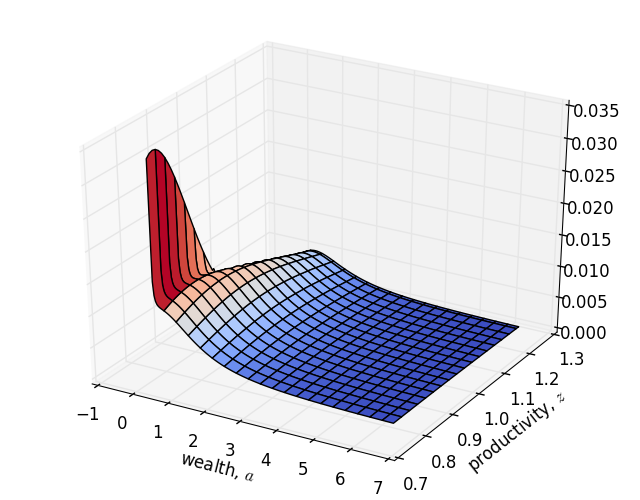

In [8]:
a_idx=200  # truncate the upper bound of the grid in order to see clear.
plot_surface(asq[1:a_idx,:], zsq[1:a_idx,:], g[1:a_idx,:], cstride=3, cmap=ColorMap("coolwarm"))
xlabel(L"wealth, $a$")
ylabel(L"productivity, $z$")
savefig("Distribution_Continuous_Types.pdf")

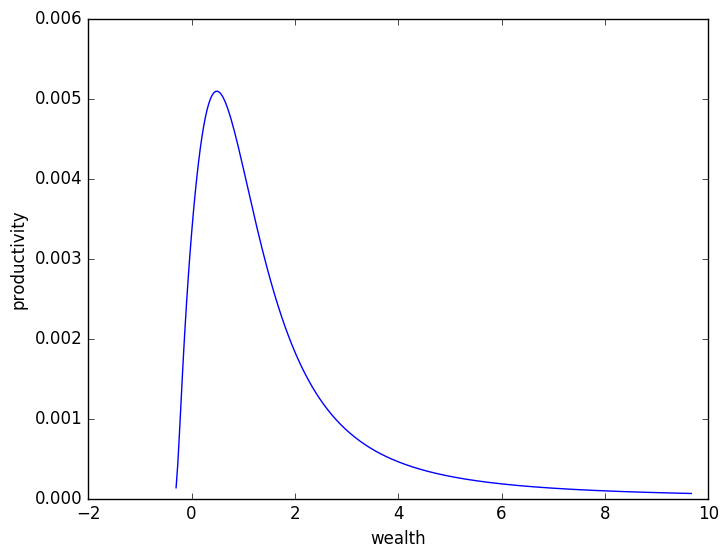

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x318f426d8>

In [9]:
# This is an example of the type of plots done in the movie.
# It is one "slide", the movie is this graph and the "z" variable moves.
# You can easily change the variable 'idxz' in order to see other slides.

idxa= 300
idxz = 50
x = h.a[1:idxa]
y = g[1:idxa,idxz]
xlabel("wealth")
ylabel("productivity")
plot(x,y)

In [10]:
#  define iterpolation object used in order to make the movie.

using Interpolations

xa = h.a[1:idxa]
yz = h.z[1:idxz]
zmin = yz[1]
zmax = yz[end]
Z = g[1:idxa,1:idxz]

knots = (xa,yz)
itp = interpolate(knots, Z, Gridded(Linear()))

300x50 Interpolations.GriddedInterpolation{Float64,2,Float64,Interpolations.Gridded{Interpolations.Linear},Tuple{Array{Float64,1},Array{Float64,1}},0}:
  0.00667593   -0.00621769   -0.020513     …  -0.678098    -0.692393  
  0.00289456   -0.00274009   -0.00905494      -0.299538    -0.305853  
  0.00139237   -0.00128502   -0.00423997      -0.140168    -0.143123  
  0.000770631  -0.000694164  -0.00228694      -0.0755548   -0.0771475 
  0.000476395  -0.000421024  -0.00138542      -0.0457477   -0.0467121 
  0.000319755  -0.000278508  -0.000915629  …  -0.0302232   -0.0308603 
  0.000228341  -0.000196664  -0.000646105     -0.0213204   -0.0217699 
  0.000171023  -0.000146005  -0.000479415     -0.0158162   -0.0161497 
  0.000132991  -0.000112742  -0.000370035     -0.0122055   -0.0124628 
  0.000106101  -8.94248e-5   -0.000293398     -0.00967618  -0.00988015
  8.12077e-5   -6.78784e-5   -0.000222592  …  -0.00733944  -0.00749415
  5.63143e-5   -4.6332e-5    -0.000151787     -0.0050027   -0.00510

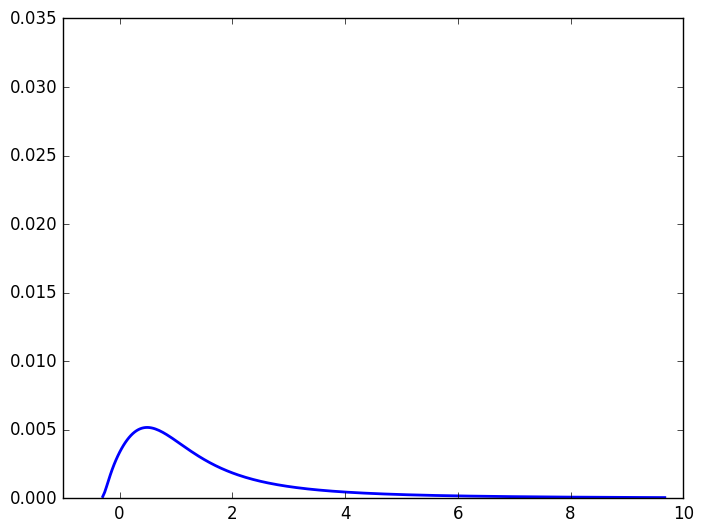

In [11]:
# This section makes the movie.

using PyCall
@pyimport matplotlib.animation as anim

# First set up the figure, the axis, and the plot element we want to animate
fig = figure()
ax = axes(xlim=(-1, 10), ylim=(0,0.035))
global line = ax[:plot]([], [], lw=2)[1]

# initialization function: plot the background of each frame
function init()
    global line
    line[:set_data]([], [])
    return (line,)
end

# animation function.  This is called sequentially
function animate(i)
    ys = zmax*(i/100) + zmin*(1-i/100)
    y = [itp[xs, ys]  for xs in x]
    global line
    line[:set_data](x, y)
    return (line,)
end

# call the animator.  blit=True means only re-draw the parts that have changed.
myanim = anim.FuncAnimation(fig, animate, init_func=init, frames=100, interval=60, blit=true)

#myanim[:save]("plots.mp4", extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
myanim[:save]("plot_wealth.mp4", extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])